In [36]:
using ResumableFunctions, StatsBase, Statistics
using FFTW, FITSIO, Intervals
using DocStringExtensions
using LinearAlgebra
using Random
using RecipesBase
using Test
using Distributions
using Printf

include("events.jl")
include("lightcurve.jl")
include("gti.jl")
include("fourier.jl")
function merge_overlapping_gtis(gtis::Matrix{Float64})
    if size(gtis, 1) <= 1
        return gtis
    end

    # Sort by start time
    sort_indices = sortperm(view(gtis, :, 1))
    sorted_gtis = gtis[sort_indices, :]

    # Pre-allocate merged array
    merged = Matrix{Float64}(undef, size(gtis, 1), 2)
    merged_count = 0

    current_start = sorted_gtis[1, 1]
    current_stop = sorted_gtis[1, 2]

    for i in 2:size(sorted_gtis, 1)
        start_time = sorted_gtis[i, 1]
        stop_time = sorted_gtis[i, 2]

        # Check if intervals overlap or touch (with small tolerance)
        if start_time <= current_stop + 1e-6
            current_stop = max(current_stop, stop_time)
        else
            # No overlap, add current interval to merged
            merged_count += 1
            merged[merged_count, 1] = current_start
            merged[merged_count, 2] = current_stop
            current_start = start_time
            current_stop = stop_time
        end
    end

    # Add the final interval
    merged_count += 1
    merged[merged_count, 1] = current_start
    merged[merged_count, 2] = current_stop

    return merged[1:merged_count, :]
end

merge_overlapping_gtis (generic function with 1 method)

In [136]:
"""
Represents a power spectrum computed from time series data.
Fields:
- freq: Frequency bins
- power: Power values for each frequency
- power_err: Uncertainties on power values
- norm: Normalization type ("frac", "leahy", "abs", "none")
- df: Frequency resolution
- nphots: Total number of photons
- m: Number of segments averaged (1 for single spectrum)
- n: Number of frequencies
- metadata: Original metadata from input data
"""
struct Powerspectrum{T}
    freq::Vector{T}          # Frequencies
    power::Vector{T}         # Power values 
    power_err::Vector{T}     # Power errors
    norm::String            # Normalization type
    df::T                   # Frequency resolution (1/(N*bin_size))
    nphots::Int            # Total number of photons
    m::Int                 # Number of segments (1 for single spectrum)
    n::Int                 # Number of frequencies
    metadata::Union{LightCurveMetadata, FITSMetadata} # Original metadata
end

"""
Represents an averaged power spectrum computed from multiple segments.
Fields:
- freq: Frequency bins
- power: Averaged power values
- power_err: Uncertainties on averaged powers
- norm: Normalization type
- df: Frequency resolution
- segment_size: Size of segments used in averaging
- nphots: Total number of photons
- m: Number of segments averaged
- mean_rate: Mean count rate
- n: Number of frequencies
- metadata: Original metadata from input data
"""
struct AveragedPowerspectrum{T}
    freq::Vector{T}         # Frequencies
    power::Vector{T}        # Averaged power values
    power_err::Vector{T}    # Errors on averaged powers
    norm::String           # Normalization type
    df::T                  # Frequency resolution
    segment_size::T        # Size of segments
    nphots::Int           # Total photons
    m::Int                # Number of segments averaged
    mean_rate::T          # Mean count rate
    n::Int                # Number of frequencies
    metadata::Union{LightCurveMetadata, FITSMetadata} # Original metadata
end

function Powerspectrum(lc::LightCurve{T}; norm::String="frac") where {T<:Real}
    bin_size = lc.metadata.bin_size
    n_bins = length(lc.counts)
    
    # Validate input
    n_bins > 1 || throw(ArgumentError("Light curve must have more than 1 bin"))
    bin_size > 0 || throw(ArgumentError("Bin size must be positive"))
    
    # Calculate FFT
    ft = fft(lc.counts)
    
    # Get frequency array in Hz
    freqs = fftfreq(n_bins, 1/bin_size)
    pos_freq_idx = positive_fft_bins(n_bins)
    freqs = freqs[pos_freq_idx]
    
    # Get frequency resolution in Hz
    df = 1 / (n_bins * bin_size) 
    
    # Calculate power
    unnorm_power = abs2.(ft[pos_freq_idx])
    
    # Normalize if requested
    power = if norm != "none"
        normalize_periodograms(
            unnorm_power,
            bin_size,
            n_bins;
            mean_flux = mean(lc.counts),
            n_ph = sum(lc.counts),
            norm = norm
        )
    else
        unnorm_power
    end
    
    # Calculate error estimates (assuming white noise)
    power_err = if norm in ["frac", "rms"]
        power ./ sqrt(1)  # For single spectrum, error = power for exponential distribution
    elseif norm == "leahy"
        fill(2.0, length(power))  # Leahy normalization has constant error of 2
    else
        sqrt.(power)  # Generic Poisson error
    end
    
    return Powerspectrum{T}(
        freqs,
        power,
        power_err,
        norm,
        df,
        sum(lc.counts),
        1,
        length(freqs),  # n: number of frequencies
        lc.metadata
    )
end

# Helper function to extract GTIs from metadata
function get_gtis_from_metadata(metadata::Union{LightCurveMetadata, FITSMetadata})
    if metadata isa FITSMetadata && !isnothing(metadata.gti)
        return metadata.gti
    elseif metadata isa LightCurveMetadata && haskey(metadata.extra, "gti")
        return metadata.extra["gti"]
    elseif metadata isa LightCurveMetadata && haskey(metadata.extra, "gti_bounds")
        # Single GTI from filtering
        bounds = metadata.extra["gti_bounds"]
        return reshape([bounds[1] bounds[2]], 1, 2)
    else
        @warn "No GTI information found in metadata. Using full time range."
        if metadata isa LightCurveMetadata
            start_time, stop_time = metadata.time_range
            return reshape([start_time stop_time], 1, 2)
        else
            # For FITSMetadata without GTI, we need to make a reasonable guess
            return nothing
        end
    end
end

"""
Validate that all generated segments are properly contained within GTIs
"""
# validation function for GTI-aware segmentation
function validate_gti_segments(segment_generator, gtis::AbstractMatrix, segment_size::Real)

    segments = collect(segment_generator)
    
    if isempty(segments)
        @warn "No valid segments generated within GTIs"
        return segments
    end
    
    valid_segments = []
    for (start_time, stop_time, start_idx, stop_idx) in segments
        # Check if segment is properly contained within a GTI
        segment_valid = false
        for i in 1:size(gtis, 1)
            gti_start, gti_stop = gtis[i, 1], gtis[i, 2]
            
            # Segment must be entirely within GTI (with small tolerance)
            if (start_time >= gti_start - 1e-6) && (stop_time <= gti_stop + 1e-6)
                segment_valid = true
                break
            end
        end
        
        if segment_valid
            push!(valid_segments, (start_time, stop_time, start_idx, stop_idx))
        else
            @debug "Rejecting segment ($start_time, $stop_time) - not fully within any GTI"
        end
    end
    
    @info "GTI validation: $(length(valid_segments))/$(length(segments)) segments are valid"
    return valid_segments
end

function AveragedPowerspectrum(lc::LightCurve{T}, segment_size::Real; 
                             norm::String="frac",
                             validate_gti::Bool=true) where T
    bin_size = lc.metadata.bin_size
    n_bins_per_segment = round(Int, segment_size / bin_size)
    
    # Validate input
    if n_bins_per_segment <= 1
        throw(ArgumentError("Segment size too small: need at least 2 bins per segment (got $n_bins_per_segment bins for segment_size=$segment_size, bin_size=$bin_size)"))
    end
    
    if segment_size <= 0
        throw(ArgumentError("Segment size must be positive"))
    end
    
    # Get GTIs from metadata
    gtis = get_gtis_from_metadata(lc.metadata)
    if isnothing(gtis)
        throw(ArgumentError("No GTI information available. Cannot create GTI-aware power spectrum."))
    end
    
    @info "Using GTIs: $(size(gtis, 1)) intervals, total exposure: $(sum(diff(gtis; dims=2))) s"
    
    # Validate GTIs
    check_gtis(gtis)
    
    # Create time array for bin centers
    times = lc.metadata.time_range[1] .+ (0:length(lc.counts)-1) .* bin_size .+ bin_size/2
    
    segment_generator = generate_indices_of_segment_boundaries_unbinned(
        times, gtis, segment_size
    )
    
    # Validate segments if validate_gti is enabled
    valid_segments = if validate_gti
        validate_gti_segments(segment_generator, gtis, segment_size)
    else
        collect(segment_generator)
    end
    
    if isempty(valid_segments)
        throw(ArgumentError("No valid segments found within GTIs for segment size $(segment_size)s"))
    end
    
    @info "Found $(length(valid_segments)) valid segments within GTIs"
    
    # Get frequency array for one segment
    freqs = fftfreq(n_bins_per_segment) ./ bin_size
    pos_freq_idx = positive_fft_bins(n_bins_per_segment)
    freqs = freqs[pos_freq_idx]
    
    # Get frequency resolution
    df = length(freqs) > 1 ? freqs[2] - freqs[1] : 1.0 / segment_size
    
    # Initialize arrays for accumulating power
    total_power = zeros(T, length(pos_freq_idx))
    total_counts = 0
    n_segments_used = 0
    
    # Track segment statistics for debugging[this can be removed]
    segment_stats = Dict(
        "zero_count_segments" => 0,
        "nan_segments" => 0,
        "boundary_violations" => 0,
        "successful_segments" => 0
    )
    
    # Process each valid segment
    for (start_time, stop_time, start_idx, stop_idx) in valid_segments
        # Convert to 1-based indexing and ensure we have valid indices
        actual_start = max(1, start_idx + 1)
        actual_stop = min(length(lc.counts), actual_start + n_bins_per_segment - 1)
        
        # More flexible validation: allow slight variations in segment length
        # but ensure minimum segment size
        actual_segment_length = actual_stop - actual_start + 1
        if actual_segment_length < n_bins_per_segment - 1  # Allow 1 bin tolerance
            @debug "Skipping segment: too short (need ≥$(n_bins_per_segment-1), have $actual_segment_length)"
            segment_stats["boundary_violations"] += 1
            continue
        end
        
        # If segment is longer than expected, truncate to exact size
        if actual_segment_length > n_bins_per_segment
            actual_stop = actual_start + n_bins_per_segment - 1
        end
        
        # Extract segment
        segment_counts = lc.counts[actual_start:actual_stop]
        
        # Skip segments with zero counts
        segment_sum = sum(segment_counts)
        if segment_sum == 0
            @debug "Skipping segment with zero counts at indices $actual_start:$actual_stop"
            segment_stats["zero_count_segments"] += 1
            continue
        end
        
        segment_mean = mean(segment_counts)
        n_segments_used += 1
        total_counts += segment_sum
        
        # Calculate FFT for this segment
        ft = fft(segment_counts)
        
        # Calculate power for positive frequencies only
        unnorm_power = abs2.(ft[pos_freq_idx])
        
        # Normalize power if requested
        power = if norm != "none"
            normalize_periodograms(
                unnorm_power,
                bin_size,
                length(segment_counts);  # Use actual segment length
                mean_flux = segment_mean,
                n_ph = segment_sum,
                norm = norm
            )
        else
            unnorm_power
        end
        
        # Sanity check for NaN values[we can remove this one too]
        if any(isnan, power)
            @warn "NaN detected in segment power, skipping" segment_sum segment_mean
            segment_stats["nan_segments"] += 1
            n_segments_used -= 1
            total_counts -= segment_sum
            continue
        end
        
        # Add to total (Bartlett's method: sum then average)
        total_power .+= power
        segment_stats["successful_segments"] += 1
    end
    
    # Report segment processing statistics
    @info "Segment processing summary:" segment_stats
    
    # Check if we have any valid segments
    if n_segments_used == 0
        throw(ArgumentError("No segments with valid (non-zero, non-NaN) data found"))
    end
    
    @info "Successfully processed $n_segments_used segments"
    
    # Calculate average power
    avg_power = total_power ./ n_segments_used
    
    # Calculate mean rate across all segments
    mean_rate = total_counts / (n_segments_used * segment_size)
    
    # Calculate errors (standard error of the mean)
    power_err = avg_power ./ sqrt(n_segments_used)
    
    return AveragedPowerspectrum{T}(
        freqs,              # Frequency bins
        avg_power,          # Averaged power values  
        power_err,          # Standard errors
        norm,               # Normalization type
        df,                 # Frequency resolution
        segment_size,       # Segment size used
        total_counts,       # Total photons from all segments
        n_segments_used,    # Number of segments averaged
        mean_rate,          # Mean count rate
        length(freqs),      # n: number of frequencies
        lc.metadata         # Original light curve metadata
    )
end

AveragedPowerspectrum

In [137]:
events = readevents("ni1200120104_0mpu7_cl.evt", load_gti=true, sort=true)

Found GTI data: 16 intervals
GTI time range: 1.3253976595089495e8 to 1.3261337476368216e8


EventList with 21244574 times and energies


In [156]:
lc = create_lightcurve(events, 0.1)

[ Info: Created light curve: 731950 bins, bin size = 0.1 s


LightCurve{Float64}([1.3254001405e8, 1.3254001415e8, 1.3254001425e8, 1.3254001435e8, 1.3254001445e8, 1.3254001455e8, 1.3254001465e8, 1.3254001475e8, 1.3254001485e8, 1.3254001495e8  …  1.3261320805e8, 1.3261320815e8, 1.3261320825e8, 1.3261320835e8, 1.3261320845e8, 1.3261320855e8, 1.3261320865e8, 1.3261320875e8, 1.3261320885e8, 1.3261320895e8], 0.1, [118, 101, 112, 155, 167, 204, 253, 167, 151, 113  …  677, 451, 321, 302, 290, 341, 352, 406, 393, 500], [10.862780491200215, 10.04987562112089, 10.583005244258363, 12.449899597988733, 12.922847983320086, 14.2828568570857, 15.905973720586866, 12.922847983320086, 12.288205727444508, 10.63014581273465  …  26.019223662515376, 21.236760581595302, 17.916472867168917, 17.378147196982766, 17.029386365926403, 18.466185312619388, 18.76166303929372, 20.149441679609886, 19.82422760159901, 22.360679774997898], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], EventProperty{Float64}[EventProperty{Floa

In [157]:
ps = Powerspectrum(lc)

Powerspectrum{Float64}([1.3662135391761732e-5, 2.7324270783523464e-5, 4.0986406175285196e-5, 5.464854156704693e-5, 6.831067695880866e-5, 8.197281235057039e-5, 9.563494774233212e-5, 0.00010929708313409385, 0.00012295921852585557, 0.00013662135391761732  …  4.999863378646082, 4.999877040781474, 4.999890702916866, 4.999904365052258, 4.9999180271876495, 4.999931689323041, 4.999945351458432, 4.999959013593824, 4.999972675729216, 4.999986337864608], [48934.81258829991, 2511.5662314050205, 9895.930162889203, 2189.3932716059444, 4211.791914583046, 2095.01725810083, 2862.7334774865444, 3386.069952399912, 3345.5649471123324, 8343.087989548285  …  0.0893114052581714, 0.053877114582617305, 0.02745410456644777, 0.04566658579727494, 0.03884709225316456, 0.02854192232541811, 0.058004734286808024, 0.07242759638814562, 0.054088929148272465, 0.031153591974930145], [48934.81258829991, 2511.5662314050205, 9895.930162889203, 2189.3932716059444, 4211.791914583046, 2095.01725810083, 2862.7334774865444, 3386.

In [158]:
segment_size=1e3
avg_ps = AveragedPowerspectrum(lc, segment_size; norm="frac", validate_gti=true)

┌ Warning: No GTI information found in metadata. Using full time range.
└ @ Main In[136]:124
[ Info: Using GTIs: 1 intervals, total exposure: 73194.99961066246 s
[ Info: GTI validation: 73/73 segments are valid
[ Info: Found 73 valid segments within GTIs
┌ Info: Segment processing summary:
│   segment_stats =
│    Dict{String, Int64} with 4 entries:
│      "successful_segments" => 14
│      "zero_count_segments" => 59
│      "boundary_violations" => 0
└      "nan_segments"        => 0
[ Info: Successfully processed 14 segments


AveragedPowerspectrum{Float64}([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01  …  4.99, 4.9910000000000005, 4.992, 4.993, 4.994, 4.995, 4.996, 4.997, 4.998, 4.999], [1053.4209073008885, 670.2956253450237, 520.3454781208169, 388.8497333899833, 334.16936055014156, 291.7223391378861, 257.0407576300914, 243.68584118819194, 229.5480633989284, 210.52057759493184  …  0.015985213227565107, 0.01586365241337458, 0.01936333921130304, 0.019528631091603545, 0.02351041056354194, 0.0284068254044301, 0.028183247325126986, 0.029561478805723778, 0.03292456615106573, 0.03234170077779359], [281.53857994174837, 179.14404127817616, 139.06817870608378, 103.92446266312206, 89.31051830971155, 77.96607465158888, 68.69703210632869, 65.12778055243, 61.349300502589536, 56.263991016142384  …  0.004272227939433965, 0.004239739445265518, 0.005175070085184395, 0.005219246198391547, 0.006283421525083201, 0.007592043436377396, 0.007532289681238451, 0.007900637538385548, 0.00879946043

In [159]:
function diagnose_gti_coverage(lc::LightCurve, segment_size::Real)
    gtis = get_gtis_from_metadata(lc.metadata)
    if isnothing(gtis)
        @warn "No GTI information available for diagnosis"
        return
    end
    
    bin_size = lc.metadata.bin_size
    times = lc.metadata.time_range[1] .+ (0:length(lc.counts)-1) .* bin_size .+ bin_size/2
    
    # Get all potential segments using the correct function signature
    segment_generator = generate_indices_of_segment_boundaries_binned(
        times, gtis, segment_size; dt=bin_size
    )
    segments = collect(segment_generator)
    
    println("\n=== GTI Coverage Diagnosis ===")
    println("Light curve: $(length(lc.counts)) bins, bin size = $(bin_size) s")
    println("Time range: $(minimum(times)) to $(maximum(times)) s")
    println("GTIs: $(size(gtis, 1)) intervals")
    
    for (i, gti_row) in enumerate(eachrow(gtis))
        gti_start, gti_stop = gti_row[1], gti_row[2]
        gti_duration = gti_stop - gti_start
        println("  GTI $i: $(gti_start) to $(gti_stop) s (duration: $(gti_duration) s)")
    end
    
    println("\nSegments: $(length(segments)) total")
    for (i, (start_time, stop_time, start_idx, stop_idx)) in enumerate(segments)
        segment_duration = stop_time - start_time
        # Check which GTI contains this segment
        containing_gti = "NONE"
        for (j, gti_row) in enumerate(eachrow(gtis))
            gti_start, gti_stop = gti_row[1], gti_row[2]
            if start_time >= gti_start && stop_time <= gti_stop
                containing_gti = "GTI_$j"
                break
            end
        end
        
        if i <= 10  # Show first 10 segments
            println("  Segment $i: $(start_time) to $(stop_time) s, duration $(segment_duration) s, in $containing_gti")
        elseif i == 11 && length(segments) > 10
            println("  ... (showing first 10 of $(length(segments)) segments)")
        end
    end
    
    # Check for data gaps
    total_gti_exposure = sum(diff(gtis; dims=2))
    total_time_range = maximum(times) - minimum(times)
    gap_fraction = 1.0 - total_gti_exposure / total_time_range
    
    println("\nData quality:")
    println("  Total time range: $(total_time_range) s")
    println("  Total GTI exposure: $(total_gti_exposure) s")
    println("  Gap fraction: $(round(gap_fraction * 100, digits=1))%")
    
    return segments, gtis
end
diagnose_gti_coverage(lc, segment_size)


=== GTI Coverage Diagnosis ===
Light curve: 731950 bins, bin size = 0.1 s
Time range: 1.3254001405020401e8 to 1.3261320895020401e8 s
GTIs: 1 intervals
  GTI 1: 1.3254001400020401e8 to 1.3261320899981467e8 s (duration: 73194.99961066246 s)

Segments: 73 total
  Segment 1: 1.3254001400020401e8 to 1.3254101390020402e8 s, duration 999.9000000059605 s, in GTI_1
  Segment 2: 1.3254101400020401e8 to 1.3254201390020402e8 s, duration 999.9000000059605 s, in GTI_1
  Segment 3: 1.3254201400020401e8 to 1.3254301390020402e8 s, duration 999.9000000059605 s, in GTI_1
  Segment 4: 1.3254301400020401e8 to 1.3254401390020402e8 s, duration 999.9000000059605 s, in GTI_1
  Segment 5: 1.3254401400020401e8 to 1.3254501390020402e8 s, duration 999.9000000059605 s, in GTI_1
  Segment 6: 1.3254501400020401e8 to 1.3254601390020402e8 s, duration 999.9000000059605 s, in GTI_1
  Segment 7: 1.3254601400020401e8 to 1.3254701390020402e8 s, duration 999.9000000059605 s, in GTI_1
  Segment 8: 1.3254701400020401e8 to 1.3

┌ Warning: No GTI information found in metadata. Using full time range.
└ @ Main In[136]:124


(Any[(1.3254001400020401e8, 1.3254101390020402e8, 0, 10000), (1.3254101400020401e8, 1.3254201390020402e8, 10000, 20000), (1.3254201400020401e8, 1.3254301390020402e8, 20000, 30000), (1.3254301400020401e8, 1.3254401390020402e8, 30000, 40000), (1.3254401400020401e8, 1.3254501390020402e8, 40000, 50000), (1.3254501400020401e8, 1.3254601390020402e8, 50000, 60000), (1.3254601400020401e8, 1.3254701390020402e8, 60000, 70000), (1.3254701400020401e8, 1.3254801390020402e8, 70000, 80000), (1.3254801400020401e8, 1.3254901390020402e8, 80000, 90000), (1.3254901400020401e8, 1.3255001390020402e8, 90000, 100000)  …  (1.3260301400020401e8, 1.3260401390020402e8, 630000, 640000), (1.3260401400020401e8, 1.3260501390020402e8, 640000, 650000), (1.3260501400020401e8, 1.3260601390020402e8, 650000, 660000), (1.3260601400020401e8, 1.3260701390020402e8, 660000, 670000), (1.3260701400020401e8, 1.3260801390020402e8, 670000, 680000), (1.3260801400020401e8, 1.3260901390020402e8, 680000, 690000), (1.3260901400020401e8, 

In [160]:
# Access frequency and power arrays
freqs = ps.freq
power = ps.power

# For averaged spectruōm
avg_freqs = avg_ps.freq  
avg_power = avg_ps.power

# noise reduction
println("Single spectrum noise level: ", std(ps.power[end-100:end]))
println("Averaged spectrum noise level: ", std(avg_ps.power[end-100:end]))

Single spectrum noise level: 0.038308065391872204
Averaged spectrum noise level: 0.017012761838184707


In [161]:
# theoretical vs actual noise reduction
println("Number of segments used: ", avg_ps.m)
theoretical_reduction = sqrt(avg_ps.m)
actual_reduction = 0.038308065391872204 / 0.001135552971324592
println("Theoretical noise reduction[Bartlett's method:]: ", theoretical_reduction)
println("Actual noise reduction: ", actual_reduction)
println("Efficiency: ", actual_reduction / theoretical_reduction * 100, "%")

Number of segments used: 14
Theoretical noise reduction[Bartlett's method:]: 3.7416573867739413
Actual noise reduction: 33.73516371251874
Efficiency: 901.6101749926712%


In [162]:
println(avg_ps.n)

4999


In [ ]:
println(avg_ps.power)

In [163]:
println(avg_ps.df)

0.001


In [164]:
println(avg_ps.m)

14


In [165]:
println(avg_ps.n)

4999


In [166]:
println(avg_ps.nphots)

20366570


In [151]:
println(avg_ps.mean_rate)

1454.8305


In [ ]:
println(avg_ps.power_err)

In [152]:
using RecipesBase

# Recipe for single Powerspectrum
@recipe function f(ps::Powerspectrum; 
                   plot_errors = true, 
                   log_scale = true,
                   frequency_unit = "Hz")
    
    # Set default attributes
    if log_scale
        xscale --> :log10
        yscale --> :log10
        xlabel --> "Frequency ($frequency_unit)"
        ylabel --> "Power ($(ps.norm) norm)"
    else
        xlabel --> "Frequency ($frequency_unit)"  
        ylabel --> "Power ($(ps.norm) norm)"
    end
    
    title --> "Power Spectrum ($(ps.norm) normalization)"
    legend --> plot_errors
    linewidth --> 1.5
    
    # Main power spectrum
    @series begin
        seriestype := :line
        label := plot_errors ? "Power" : ""
        color := :blue
        ps.freq, ps.power
    end
    
    # Error bars if requested
    if plot_errors && !isnothing(ps.power_err)
        @series begin
            seriestype := :scatter
            yerror := ps.power_err
            label := "± 1σ errors"
            markersize := 1
            markerstrokewidth := 0
            color := :red
            alpha := 0.3
            ps.freq, ps.power
        end
    end
end

# Recipe for AveragedPowerspectrum  
@recipe function f(aps::AveragedPowerspectrum;
                   plot_errors = true,
                   log_scale = true, 
                   frequency_unit = "Hz")
    
    # Set default attributes
    if log_scale
        xscale --> :log10
        yscale --> :log10 
        xlabel --> "Frequency ($frequency_unit)"
        ylabel --> "Power ($(aps.norm) norm)"
    else
        xlabel --> "Frequency ($frequency_unit)"
        ylabel --> "Power ($(aps.norm) norm)" 
    end
    
    title --> "Averaged Power Spectrum ($(aps.m) segments, $(aps.norm) norm)"
    legend --> plot_errors
    linewidth --> 2
    
    # Main averaged power spectrum
    @series begin
        seriestype := :line
        label := plot_errors ? "Averaged Power" : ""
        color := :blue
        aps.freq, aps.power
    end
    
    # Error bars if requested
    if plot_errors && !isnothing(aps.power_err)
        @series begin
            seriestype := :scatter  
            yerror := aps.power_err
            label := "± 1σ errors ($(aps.m) segments)"
            markersize := 1
            markerstrokewidth := 0
            color := :orange
            alpha := 0.4
            aps.freq, aps.power
        end
    end
end

# Recipe for comparing multiple power spectra - this handles Vector input
@recipe function f(spectra::Vector{T};
                   log_scale = true,
                   frequency_unit = "Hz") where T <: Union{Powerspectrum, AveragedPowerspectrum}
    
    # Set default attributes
    if log_scale
        xscale --> :log10
        yscale --> :log10
        xlabel --> "Frequency ($frequency_unit)"
        ylabel --> "Power"
    else
        xlabel --> "Frequency ($frequency_unit)"
        ylabel --> "Power"
    end
    
    title --> "Power Spectrum Comparison"
    legend --> :topright
    linewidth --> 2
    
    colors = [:blue, :red, :green, :purple, :orange, :brown, :pink, :gray]
    
    for (i, ps) in enumerate(spectra)
        @series begin
            seriestype := :line
            color := colors[mod1(i, length(colors))]
            if isa(ps, AveragedPowerspectrum)
                label := "Averaged ($(ps.m) seg, $(ps.norm))"
            else
                label := "Single ($(ps.norm))" 
            end
            ps.freq, ps.power
        end
    end
end

# Specialized recipe for QPO detection plots
@recipe function f(ps::Union{Powerspectrum, AveragedPowerspectrum}, ::Type{Val{:qpo}};
                   qpo_range = (0.1, 100),
                   noise_level = nothing)
    
    # Focus on QPO frequency range
    freq_mask = (ps.freq .>= qpo_range[1]) .& (ps.freq .<= qpo_range[2])
    
    xscale --> :log10
    yscale --> :log10
    xlabel --> "Frequency (Hz)" 
    ylabel --> "Power × Frequency"
    title --> "QPO Search Plot"
    legend --> :topright
    linewidth --> 2
    
    # Plot Power × Frequency (flattens continuum)
    @series begin
        seriestype := :line
        label := isa(ps, AveragedPowerspectrum) ? "Averaged ($(ps.m) seg)" : "Single"
        color := :blue
        ps.freq[freq_mask], ps.power[freq_mask] .* ps.freq[freq_mask]
    end
    
    # Add noise level if provided
    if !isnothing(noise_level)
        freq_range = ps.freq[freq_mask]
        noise_y = noise_level * mean(freq_range)
        @series begin
            seriestype := :hline
            label := "Noise Level"
            color := :red
            linestyle := :dash
            linewidth := 2
            y := [noise_y]
        end
    end
end

In [153]:
using Plots

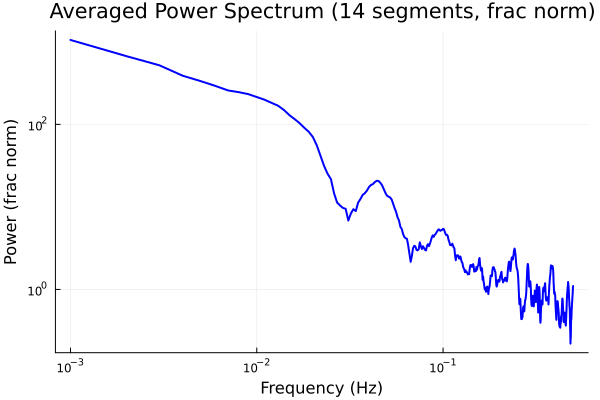

In [154]:
plot(avg_ps,plot_errors=false,frequency_unit="Hz")

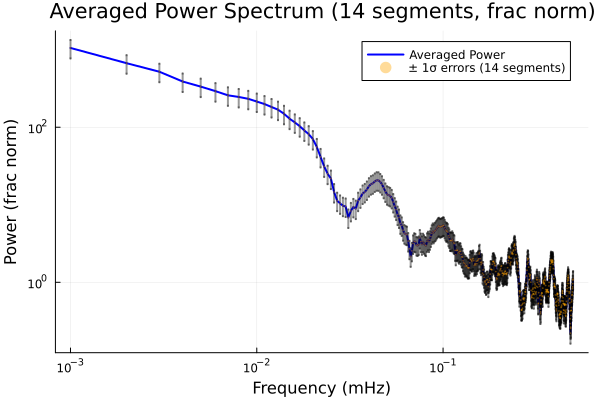

In [155]:
plot(avg_ps, plot_errors=true, frequency_unit="mHz")